## Starting my own model

In [1]:
import pandas as pd
import pickle
from gensim.models.phrases import Phrases, Phraser

In [2]:
with open("df_clean_sub_date.csv", "rb") as fp:   # Unpickling
    df_clean = pickle.load(fp)

In [3]:
df_clean = df_clean[~df_clean.clean.str.contains("gt...")]

In [4]:
sent = [row.split() for row in df_clean['clean']]

In [5]:
phrases = Phrases(sent, min_count=30)

In [6]:
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
with open("./data/sentences.txt", "wb") as fp:  # Pickling
    pickle.dump(sentences, fp)

In [2]:
import multiprocessing

from gensim.models import Word2Vec

In [5]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [6]:
parameters = dict(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [28]:
w2v_model = Word2Vec(**parameters)

### Google Model

In [ ]:
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
google_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [ ]:
google_model.most_similar(positive=["man"])

### Fine Tunning

In [ ]:
w2v_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)

In [ ]:
w2v_model.train(sentences[:100000], total_examples=w2v_model.corpus_count, epochs=30)

In [ ]:
w2v_model.wv.most_similar(positive=["incel"])

### DataFrame by Community

In [7]:
MR_subreddits = ['LadyMRAs', 'FeMRADebates', 'Masculism', 'MensRants', 'FeMRA', 'MRActivism',
                 'MensRightsLaw', 'MRRef']  # removed againstmansrights

Incel_subreddits = ['askanincel', 'BlackPillScience', 'IncelsWithoutHate', 'Braincels']

MGTOW_subreddits = ['MGTOW']

RedPill_subreddits = ['RedPillParenting', 'TRPOffTopic', 'GEOTRP', 'thankTRP', 'redpillbooks',
                      'becomeaman', 'RedPillWomen', 'TheBluePill', 'asktrp', 'TheRedPill']  # removed exredpill

In [8]:
MR_df = df_clean.loc[df_clean['subreddit'].isin(MR_subreddits)]
Incel_df = df_clean.loc[df_clean['subreddit'].isin(Incel_subreddits)]
MGTOW_df = df_clean.loc[df_clean['subreddit'].isin(MGTOW_subreddits)]
RedPill_df = df_clean.loc[df_clean['subreddit'].isin(RedPill_subreddits)]

## Community Models

In [9]:
reddits_df = [MR_df, Incel_df, MGTOW_df, RedPill_df]
reddits = ['MR', 'Incel', 'MGTOW', 'RedPill']

In [10]:
for i in range(4):
    sub_sent = [row.split() for row in reddits_df[i]['clean']]
    sub_phrases = Phrases(sub_sent, min_count=30)
    sub_bigram = Phraser(sub_phrases)
    sub_sentences = sub_bigram[sub_sent]

    Model = Word2Vec(**parameters)
    Model.build_vocab(sub_sentences)
    Model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)
    Model.train(sub_sentences, total_examples=Model.corpus_count, epochs=30)

    Model.init_sims(replace=True)
    Model.wv.save(f"{reddits[i]}_wordvectors.kv")
    print(f"{reddits[i]}_wordvectors.kv saved")

MR_wordvectors.kv saved
Incel_wordvectors.kv saved
MGTOW_wordvectors.kv saved
RedPill_wordvectors.kv saved


### Time models

In [ ]:
years = ['2014', '2015', '2016', '2017', '2018']

In [6]:
def time_model_creation(model_df):
    
    models = []
    
    sub = model_df.subreddit[0]
    print(sub)
    
    # Creating Year Collumn
    model_df['Publish Date'] = pd.to_datetime(model_df['Publish Date'])
    model_df['year'] = model_df['Publish Date'].dt.year
    model_df['year'] = model_df['year'].mask(model_df['year'] < 2015)
    model_df['year'] = model_df['year'].fillna(2014)
   
    print('Year collumn created')
    
    for year in years:
        
        # Creating Sentences by time
        time_df = model_df.loc[model_df['year'] == year]
        time_sent = [row.split() for row in time_df['clean']]
        time_phrases = Phrases(time_sent, min_count=30)
        time_bigram = Phraser(time_phrases)
        time_sentences = time_bigram[time_sent]
        
        print(f'Year {year} sentences created')
        
        # Creating time Model
        Model = Word2Vec(**parameters)
        Model.build_vocab(model_sentences[start:end])
        Model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)
        Model.train(model_sentences[start:end], total_examples=Model.corpus_count, epochs=30)
        
        Model.init_sims(replace=True)
        Model.wv.save(f"{sub}_wordvectors_{year}.kv")
        
        models.append(Model)
        
        print(f"Created {sub}_wordvectors_{year}.kv")
        
    return models

In [105]:
MR_models = time_model_creation(MR_sentences)

added model 0
added model 1


### Comparing models

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set()

In [4]:
def comparing_models(model1, model2, word, community='Reddit', title1='First 1%', title2='Last 1%'):
    G1 = nx.Graph()
    G2 = nx.Graph()
    G1.add_node(word)
    G2.add_node(word)
    
    for close_word in model1.wv.most_similar(positive=[word], topn=5):
        close_word=close_word[0]
        G1.add_node(close_word)
        G1.add_edge(word, close_word)
        G1[word][close_word]['weight'] = model1.wv.similarity(word, close_word)
        
        for other_word in model1.wv.most_similar(positive=[close_word], topn=3):
            other_word = other_word[0]
            G1.add_node(other_word)
            G1.add_edge(close_word, other_word)
            G1[close_word][other_word]['weight'] = model1.wv.similarity(close_word, other_word)
            
    for close_word in model2.wv.most_similar(positive=[word], topn=5):
        close_word=close_word[0]
        G2.add_node(close_word)
        G2.add_edge(word, close_word)
        G2[word][close_word]['weight'] = model2.wv.similarity(word, close_word)
        
        for other_word in model2.wv.most_similar(positive=[close_word], topn=3):
            other_word = other_word[0]
            G2.add_node(other_word)
            G2.add_edge(close_word, other_word)
            G2[close_word][other_word]['weight'] = model2.wv.similarity(close_word, other_word)
            
    plt.figure(figsize=(20, 17))
    
    plt.subplot(221, title=title1)
    nx.draw(G1, with_labels=True, node_color = 'skyblue', font_size=15)
    
    ax2 = plt.subplot(222, title=title2)
    nx.draw(G2, with_labels=True, node_color = 'skyblue', font_size=15)

In [5]:
def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [1]:
from gensim.models import KeyedVectors

wv = KeyedVectors.load("wordvectors.kv", mmap='r')

In [129]:
cos_sim(MR_models[0].wv.__getitem__('man'), MR_models[0].wv.__getitem__('red'))

-0.041616455

In [130]:
MR_models[0].wv.similarity('man', 'red')

-0.041616447

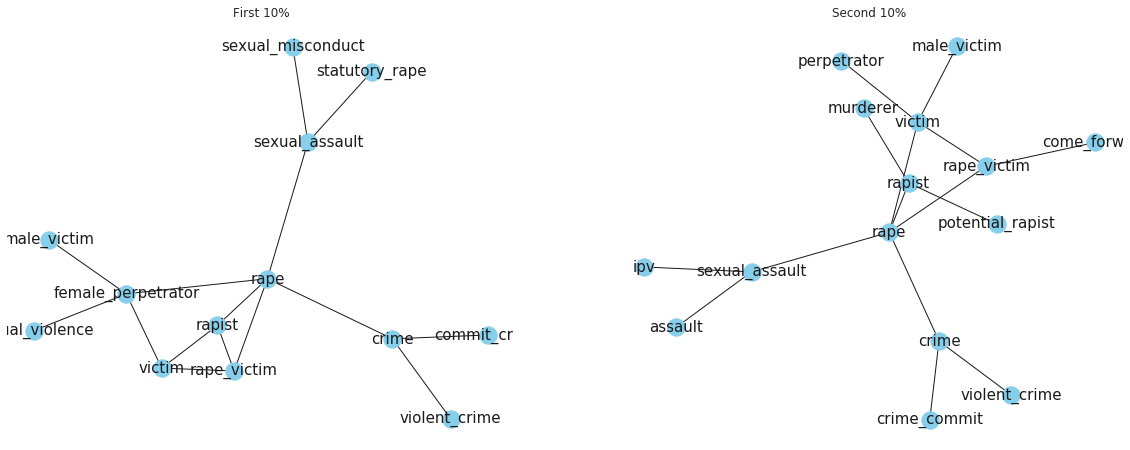

In [142]:
comparing_models(MR_models[0], MR_models[1], 'rape', community='MR', title1='First 10%', title2='Second 10%')

##### T-SNE  Visualization algorithm (William L. Hamilton paper)

To visualize semantic change for a wordwiin twodimensions we employed the following procedure,which  relies  on  the  t-SNE  embedding  method(Van der Maaten and Hinton, 2008) as a subrou-tine:

* 1.  Find  the  union  of  the  wordwi’sknearestneighbors over all necessary time-points.
* 2.  Compute   the   t-SNE   embedding   of   thesewords on the most recent (i.e.,  the modern)time-point.
* 3.  For  each  of  the  previous  time-points,  holdall  embeddings  fixed,  except  for  the  targetword’s (i.e., the embedding forwi), and op-timize a new t-SNE embedding only for thetarget  word. We  found  that  initializing  theembedding for the target word to be the cen-troid  of  itsk′-nearest  neighbors  in  a  time-point was highly effective.

Thus, in this procedure the background words arealways shown in their “modern” positions, whichmakes sense given that these are the current mean-ings of these words. This approximation is neces-sary, since in reality all words are moving.

#### Aligning historical embeddings

We   use   orthogonal   Procrustes   to   align   thelearned  low-dimensional  embeddings.    DefiningW(t)∈Rd×|V|as the matrix of word embeddingslearned  at  yeart,  we  align  across  time-periodswhile preserving cosine similarities by optimizing:

$R(t)= arg   minQ>Q=I‖QW(t)−W(t+1)‖F $

The  solution  correspondsto  the  best  rotational  alignment  and  can  be  ob-tained  efficiently  using  an  application  of  SVD

##### Pair-wise  similarity  time-series

$ s(t)(wi,wj) =cos-sim(w(t)i,w(t)j) $

In [18]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline